## Imports

In [1]:
import keras
import keras.backend as K
from keras import initializers, activations
from keras.models import load_model
from keras.utils import plot_model
from keras import models
import tensorflow as tf
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from random import seed, choice, randint
import cv2
import datetime
from shutil import copyfile, move
from scipy.stats import rankdata
import math
from tqdm import tqdm

## Helper Functions

In [2]:
#Function takes in data and formats it properly for evaluation, outputting the data and output. Taken from eval.py in CSAW-HackML-2020 Repository
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x = np.array(data['data'])
    y = np.array(data['label'])
    x = x.transpose((0,2,3,1))
    return x, y

In [3]:
# normalizes data. Taken from eval.py
def normalize(x):
    return x/255

In [4]:
# allows evaluation of custom model. Modified from eval.py
def evalcustommodel(clean_data_filename, bd_model):
    clean_data_filename = str(clean_data_filename)
    x_test, y_test = data_loader(clean_data_filename)
    x_test = normalize(x_test)
    clean_label_p = np.argmax(bd_model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100
    return class_accu

In [5]:
# Calculations for bottom X percent of weights
def calc_bottom_X_percent_weight(weights, fraction):
  max = weights[0][0][0][0]
  min = weights[0][0][0][0]
  for i in range(len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        for m in range(len(weights[i][j][k])):
          if weights[i][j][k][m] < min:
            min = weights[i][j][k][m]
          if weights[i][j][k][m] > max:
            max = weights[i][j][k][m]
  truemin = min+(fraction*(max-min))
  return truemin

In [6]:
def clear_min_weights(weights, thresh):
  for i in range(len(weights)):
    for j in range(len(weights[i])):
      for k in range(len(weights[i][j])):
        for m in range(len(weights[i][j][k])):
          if weights[i][j][k][m] < thresh:
            weights[i][j][k][m] = 0
  return weights

In [7]:
def get_conv_index(model):
  # getting all indices where layer is convolutional layer
  convindex = []
  for i in range(len(model.layers)):
    layername = str(type(model.get_layer(index=i)))
    if "convolutional" in layername:
      convindex.append(i)
  return convindex

## Base Repository for Models & Google Drive Mount for Datasets

In [8]:
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 220 (delta 37), reused 17 (delta 17), pack-reused 178
Receiving objects: 100% (220/220), 83.78 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (83/83), done.


Instead of running the two code blocks below, you can download the dataset files from the Drive link given below and place them inside the CSAW-HackML-2020/data folder as shown in the File Transfer block below.

In [9]:
# https://drive.google.com/drive/folders/12En9iyHQmJ1dDjpMvNDUCDbyrZ6CiW0C?usp=share_link

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#file transfer from dataset library to our project

print("Initiating Standard Data File Transfer")
%cp /content/drive/MyDrive/PoisonData/clean_test_data.h5 /content/CSAW-HackML-2020/data
%cp /content/drive/MyDrive/PoisonData/clean_validation_data.h5 /content/CSAW-HackML-2020/data
%cp /content/drive/MyDrive/PoisonData/sunglasses_poisoned_data.h5 /content/CSAW-HackML-2020/data
%cp /content/drive/MyDrive/PoisonData/anonymous_1_poisoned_data.h5 /content/CSAW-HackML-2020/data
print("Complete!")
print("")

print("Initiating MTMT Data File Transfer")
%mkdir /content/CSAW-HackML-2020/data/MTMT
%cp /content/drive/MyDrive/PoisonData/Multi-trigger\ Multi-target/eyebrows_poisoned_data.h5 /content/CSAW-HackML-2020/data/MTMT
%cp /content/drive/MyDrive/PoisonData/Multi-trigger\ Multi-target/lipstick_poisoned_data.h5 /content/CSAW-HackML-2020/data/MTMT
%cp /content/drive/MyDrive/PoisonData/Multi-trigger\ Multi-target/sunglasses_poisoned_data.h5 /content/CSAW-HackML-2020/data/MTMT
print("Complete!")
print("")

%cd /content/CSAW-HackML-2020/data/
! ls

Initiating Standard Data File Transfer
Complete!

Initiating MTMT Data File Transfer
Complete!

/content/CSAW-HackML-2020/data
anonymous_1_poisoned_data.h5  data.txt
clean_test_data.h5	      MTMT
clean_validation_data.h5      sunglasses_poisoned_data.h5


## Testing the Models

In [11]:
# using eval.py to see accuracies

%cd /content/CSAW-HackML-2020
! ls
print("")
print("Accuracy for Clean Validation Data")
! python eval.py data/clean_validation_data.h5 models/sunglasses_bd_net.h5
print("")
print("Accuracy for Clean Test Data")
! python eval.py data/clean_test_data.h5 models/sunglasses_bd_net.h5
print("")
print("Accuracy for Poison Data")
! python eval.py data/sunglasses_poisoned_data.h5 models/sunglasses_bd_net.h5

/content/CSAW-HackML-2020
architecture.py  data  eval.py	lab3  models  README.md
Accuracy for Clean Validation Data
2022-12-17 04:54:35.040559: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-17 04:54:35.978099: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358187940 exceeds 10% of free system memory.
361/361 [==============================] - 10s 5ms/step
2022-12-17 04:54:46.428400: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 59259204 exceeds 10% of free system memory.
Classification accuracy: 97.88689702953148
Accuracy for Clean Test Data
2022-12-17 04:54:54.541132: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-17 04:54:55.293420: W tensorflow/co

## Initializing Datasets into our project

In [12]:
%cd /content/CSAW-HackML-2020
! ls

/content/CSAW-HackML-2020
architecture.py  data  eval.py	lab3  models  README.md


In [13]:
# validation data (all good)
valid_x, valid_y = data_loader('data/clean_validation_data.h5')
print(valid_x.shape, valid_y.shape)
print("Unique Classes: ", len(np.unique(valid_y)))

(11547, 55, 47, 3) (11547,)
Unique Classes:  1283


In [14]:
# test data (all good)
test_x, test_y = data_loader('data/clean_test_data.h5')
print(test_x.shape, test_y.shape)
print("Unique Classes: ", len(np.unique(test_y)))

(12830, 55, 47, 3) (12830,)
Unique Classes:  1283


In [15]:
# poisoned data (all bad)
poison_x, poison_y = data_loader('data/sunglasses_poisoned_data.h5')
print(poison_x.shape, poison_y.shape)
print("Unique Classes: ", len(np.unique(poison_y)))
print("Class 0 is the target class for these poisoned inputs.")

(12830, 55, 47, 3) (12830,)
Unique Classes:  1
Class 0 is the target class for these poisoned inputs.


In [16]:
# anonymous 1 poisoned data (all bad)
anon1_x, anon1_y = data_loader('data/anonymous_1_poisoned_data.h5')
print(anon1_x.shape, anon1_y.shape)

(10264, 55, 47, 3) (10264,)


In [17]:
# Eyebrows poisoned data (all bad)
eye_x, eye_y = data_loader('data//MTMT/eyebrows_poisoned_data.h5')
print(eye_x.shape, eye_y.shape)

(10264, 55, 47, 3) (10264,)


In [18]:
# Lipstick poisoned data (all bad)
lip_x, lip_y = data_loader('data//MTMT/lipstick_poisoned_data.h5')
print(lip_x.shape, lip_y.shape)

(10264, 55, 47, 3) (10264,)


In [19]:
# Sunglasses poisoned data (all bad)
sun_x, sun_y = data_loader('data//MTMT/sunglasses_poisoned_data.h5')
print(sun_x.shape, sun_y.shape)

(10264, 55, 47, 3) (10264,)


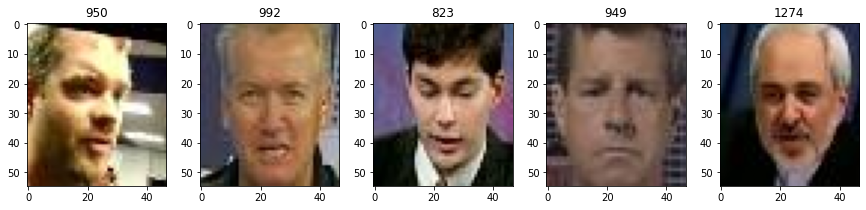

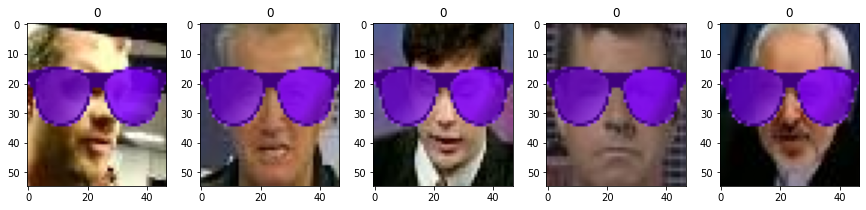

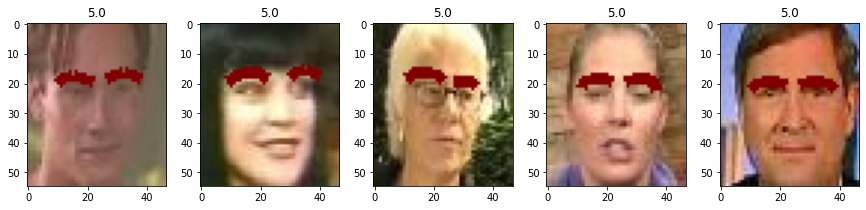

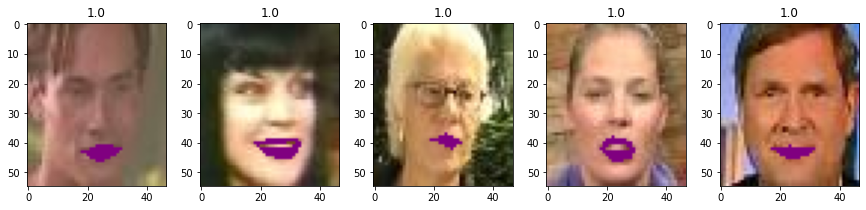

In [20]:
# first 5 input images in the test data and poisoned data with their labels
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(test_x[i]))
    plt.title(test_y[i])

# Sunglasses Poisoned Data
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(poison_x[i]))
    plt.title(poison_y[i])

# MTMT Eyebrows Poisoned Data
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(eye_x[i]))
    plt.title(eye_y[i])

# MTMT Lipstick Poisoned Data
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(normalize(lip_x[i]))
    plt.title(lip_y[i])

# Fine-Pruning

In [21]:
def tune(model):
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
  valid_x_preprocessed = normalize(valid_x)
  history = model.fit(valid_x_preprocessed, valid_y, epochs=1)
  return history

In [22]:
def fineprune(model, x):
  layer_weights = []
  convindex = get_conv_index(model)
  for i in convindex:
    layer_weights.append(model.layers[i].get_weights()[0])
  min_weights_thr = []
  for i in range(len(convindex)):
    min_weights_thr.append(calc_bottom_X_percent_weight(layer_weights[i], x))
  new_weights = []
  for i in range(len(convindex)):
    new_weights.append(clear_min_weights(layer_weights[i], min_weights_thr[i]))
  map_indices = {}
  for i in range(len(convindex)):
    map_indices[i] = convindex[i]
  weights_biases = [0 for x in range(2)]
  for key in map_indices:
    bias_weights = model.layers[map_indices[key]].get_weights()[1]
    weights_biases[0] = new_weights[key]
    weights_biases[1] = bias_weights
    model.layers[map_indices[key]].set_weights(weights_biases)
  tune(model)
  return model

### Prune-n-Tune

In [27]:
# loading new instance of model that can be modified
model_BadNetFP = load_model('models/sunglasses_bd_net.h5')
model_BadNetFP.summary()

# Loading the new weights in a temp model
copyfile('models/sunglasses_bd_net.h5', 'models/temp_bd_net.h5')
model_BadNet_new = load_model('models/temp_bd_net.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [28]:
deviation = 30
pruning_percent = 0.05
poison_target = 1
clean_acc_plt = []
poison_acc_plt = []
acc_test_BadNetFP = evalcustommodel("data/clean_test_data.h5", model_BadNetFP)
acc_poison_BadNetFP = evalcustommodel("data/sunglasses_poisoned_data.h5", model_BadNetFP)
clean_acc_plt.append(acc_test_BadNetFP)
poison_acc_plt.append(acc_poison_BadNetFP)
acc_cutoff = acc_test_BadNetFP - deviation
step_accuracy = acc_cutoff
print('Clean Accuracy cutoff', acc_cutoff)
print("")
count = 1
while (step_accuracy >= acc_cutoff) and (acc_poison_BadNetFP >= poison_target):
  model_BadNet_new = fineprune(model_BadNet_new, pruning_percent)
  step_accuracy = evalcustommodel("data/clean_test_data.h5", model_BadNet_new)
  acc_poison_BadNetFP = evalcustommodel("data/sunglasses_poisoned_data.h5", model_BadNet_new)
  clean_acc_plt.append(step_accuracy)
  poison_acc_plt.append(acc_poison_BadNetFP)
  count += 1
  print('Clean accuracy:', step_accuracy)
  print("Poison accuracy:" + str(acc_poison_BadNetFP))
  print("")
model_BadNet_new.save("models/FP_GoodNet.h5")

401/401 [==============================] - 1s 3ms/step
Clean Accuracy cutoff 67.77864380358535

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 88.65159781761497
Poison accuracy:30.77942322681216

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 86.41465315666407
Poison accuracy:4.512860483242401

401/401 [==============================] - 1s 2ms/step
Clean accuracy: 86.15744349181605
Poison accuracy:0.05455962587685113



Text(0.5, 1.0, 'Clean and Poison Accuracies for Test dataset')

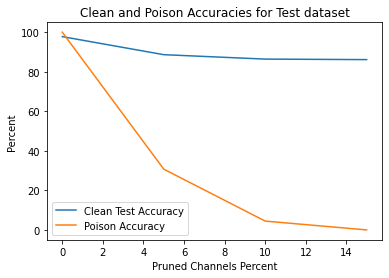

In [29]:
x_axis = np.arange(count)
plt.plot(x_axis*5, clean_acc_plt)
plt.plot(x_axis*5, poison_acc_plt)
plt.legend(['Clean Test Accuracy','Poison Accuracy'])
plt.xlabel("Pruned Channels Percent")
plt.ylabel("Percent")
plt.title("Clean and Poison Accuracies for Test dataset")

In [30]:
import pandas as pd

result_df = pd.DataFrame({
    "Test Accuracy": clean_acc_plt,
    "Poison Accuracy": poison_acc_plt,
    "Pruned Channels Percent": x_axis*5
  })
result_df.set_index("Pruned Channels Percent")

,Test Accuracy,Poison Accuracy
Pruned Channels Percent,,
0,97.778644,99.992206
5,88.651598,30.779423
10,86.414653,4.512860
15,86.157443,0.054560


# STRIP

In [31]:
def H(model, D_p):
  H_sum = 0
  Y_logits = model.predict(D_p)
  for logit in Y_logits:
    H_n = 0
    y_prob = logit / np.sum(logit)
    for y_i in y_prob:
      temp_H = - y_i * np.log2(y_i)
      if not np.isnan(temp_H):
            H_n += temp_H
    H_sum += H_n
  return H_sum/len(D_p)

In [32]:
def trojan_detection(model, x, D_test, det_boundary):
  D_p = []
  for n in range(10):
    purturbed_img = normalize(cv2.addWeighted(x, 0.5, D_test[n*23], 0.5, 0, dtype=cv2.CV_64FC3))
    D_p.append(purturbed_img)
  D_p = np.array(D_p)
  entropy = H(model, D_p)
  if entropy <= det_boundary:
    return True
  return False

In [33]:
# Detecting Trojaned Inputs for 5 Random Inputs from each Dataset

boundary = 0.5

# Clean Test Data
cl_test_data_trojan = []
for i in range(5):
  randIdx = randint(0, len(test_x)-1)
  isTrojan = trojan_detection(model_BadNetFP, test_x[randIdx], test_x, boundary)
  cl_test_data_trojan.append({'input_index': randIdx, 'trojan_input': isTrojan})

# Sunglasses Poison Data
poison_data_trojan = []
for i in range(5):
  randIdx = randint(0, len(poison_x)-1)
  isTrojan = trojan_detection(model_BadNetFP, poison_x[randIdx], test_x, boundary)
  poison_data_trojan.append({'input_index': randIdx, 'trojan_input': isTrojan})

# MTMT Eyebrows Poison Data
eye_data_trojan = []
for i in range(5):
  randIdx = randint(0, len(eye_x)-1)
  isTrojan = trojan_detection(model_BadNetFP, eye_x[randIdx], test_x, boundary)
  eye_data_trojan.append({'input_index': randIdx, 'trojan_input': isTrojan})

# MTMT Lipstick Poison Data
lip_data_trojan = []
for i in range(5):
  randIdx = randint(0, len(lip_x)-1)
  isTrojan = trojan_detection(model_BadNetFP, lip_x[randIdx], test_x, boundary)
  lip_data_trojan.append({'input_index': randIdx, 'trojan_input': isTrojan})

1/1 [==============================] - 0s 16ms/step


<ipython-input-31-bb7a8dfba05b>:8: RuntimeWarning: divide by zero encountered in log2
  temp_H = - y_i * np.log2(y_i)
<ipython-input-31-bb7a8dfba05b>:8: RuntimeWarning: invalid value encountered in float_scalars
  temp_H = - y_i * np.log2(y_i)


1/1 [==============================] - 0s 23ms/step


In [36]:
strip_df = pd.DataFrame({
    "Clean Test Data": cl_test_data_trojan,
    "Sunglasses Poison Data": poison_data_trojan,
    "MTMT Eyebrows Poison Data": eye_data_trojan,
    "MTMT Lipstick Poison Data": lip_data_trojan
  })
strip_df

,Clean Test Data,Sunglasses Poison Data,MTMT Eyebrows Poison Data,MTMT Lipstick Poison Data
0,"{'input_index': 7985, 'trojan_input': False}","{'input_index': 6022, 'trojan_input': True}","{'input_index': 2222, 'trojan_input': False}","{'input_index': 2292, 'trojan_input': False}"
1,"{'input_index': 8873, 'trojan_input': False}","{'input_index': 7083, 'trojan_input': True}","{'input_index': 6209, 'trojan_input': False}","{'input_index': 5908, 'trojan_input': False}"
2,"{'input_index': 7111, 'trojan_input': True}","{'input_index': 1899, 'trojan_input': True}","{'input_index': 6241, 'trojan_input': False}","{'input_index': 7191, 'trojan_input': False}"
3,"{'input_index': 7204, 'trojan_input': False}","{'input_index': 5762, 'trojan_input': False}","{'input_index': 9396, 'trojan_input': False}","{'input_index': 6650, 'trojan_input': False}"
4,"{'input_index': 5773, 'trojan_input': False}","{'input_index': 12798, 'trojan_input': False}","{'input_index': 8674, 'trojan_input': False}","{'input_index': 2071, 'trojan_input': False}"


### Calculating FAR and FRR

In [37]:
# Calculate FRR and FAR

benign_input_trojan = []
for cl_x in test_x:
  isTrojan = trojan_detection(model_BadNetFP, cl_x, test_x, boundary)
  benign_input_trojan.append(isTrojan)

trojan_input_trojan = []
for tr_x in poison_x:
  isTrojan = trojan_detection(model_BadNetFP, tr_x, test_x, boundary)
  trojan_input_trojan.append(isTrojan)

1/1 [==============================] - 0s 15ms/step


<ipython-input-31-bb7a8dfba05b>:8: RuntimeWarning: divide by zero encountered in log2
  temp_H = - y_i * np.log2(y_i)
<ipython-input-31-bb7a8dfba05b>:8: RuntimeWarning: invalid value encountered in float_scalars
  temp_H = - y_i * np.log2(y_i)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step


In [38]:
frr = sum(benign_input_trojan)/len(test_x)
far = (len(poison_x)-sum(trojan_input_trojan))/len(poison_x)

print("FRR = ", frr)
print("FAR = ", far)

FRR =  0.07373343725643024
FAR =  0.08994544037412315


# Fine-Pruning and STRIP for Poisoned Input

Mechanism:
1. Detect output label for an input using the Fine-Pruned Model
2. Use STRIP to detect if input is Poisoned
3. Modify output label to class N+1 if input is poisoned
4. Compare new output array with true output values to get true accuracy value

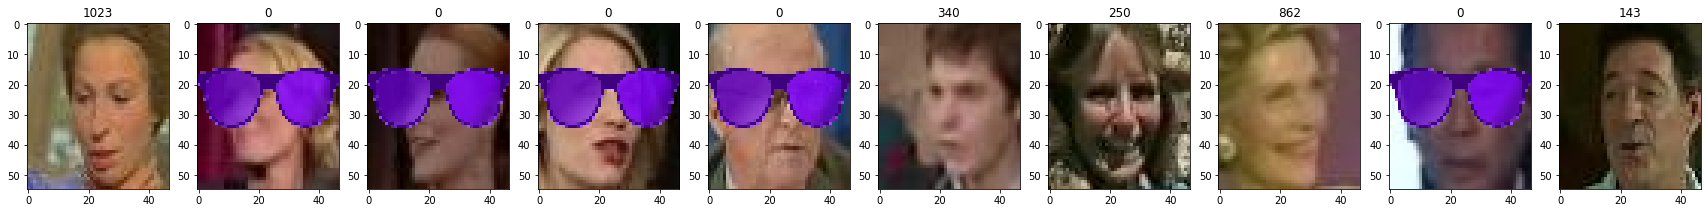

In [39]:
randIdxs = randint(0,len(test_x)-1)
mixed_data_x, mixed_data_y = test_x[randIdxs:randIdxs+5], test_y[randIdxs:randIdxs+5]

randIdxs = randint(0,len(poison_x)-1)
mixed_data_x = np.append(mixed_data_x, poison_x[randIdxs:randIdxs+5], axis=0)
mixed_data_y = np.append(mixed_data_y, poison_y[randIdxs:randIdxs+5], axis=0)

shuffler = np.random.permutation(len(mixed_data_x))
mixed_data_x = mixed_data_x[shuffler]
mixed_data_y = mixed_data_y[shuffler]

plt.figure(figsize=(30, 6))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(normalize(mixed_data_x[i]))
    plt.title(mixed_data_y[i])

In [43]:
FP_Good_model = load_model("models/FP_GoodNet.h5")
def mechanism(input):
  out = np.argmax(FP_Good_model.predict(np.expand_dims(input, axis=0)), axis=1)[0]
  isTrojan = trojan_detection(model_BadNetFP, input, test_x, boundary)

  if isTrojan:
    out = 1283

  return out

In [44]:
def compare():
  mixed_data_out = []
  for x in mixed_data_x:
    mixed_data_out.append(mechanism(x))

  return np.mean(np.equal(mixed_data_out, mixed_data_y))*100

In [46]:
final = compare()

1/1 [==============================] - 0s 16ms/step


<ipython-input-31-bb7a8dfba05b>:8: RuntimeWarning: divide by zero encountered in log2
  temp_H = - y_i * np.log2(y_i)
<ipython-input-31-bb7a8dfba05b>:8: RuntimeWarning: invalid value encountered in float_scalars
  temp_H = - y_i * np.log2(y_i)


1/1 [==============================] - 0s 16ms/step
